# Geophysical tutorial: Step-by-step NMO correction

by [Leonardo Uieda](http://www.leouieda.com)

*This is a part of The Leading Edge [tutorials
series](https://dx.doi.org/10.1190/tle35020190.1).*

Open any text book about seismic data processing and you will inevitably find a
section about the Normal Moveout (NMO) correction.
When applied to a Common Mid Point (CMP) section, the correction is supposed to
turn the hyperbola associated with a reflection into a straight horizontal
line.
What most text books won't tell you is *how, exactly, do you apply this
equation to the data*?

That is what this tutorial will teach you (hopefully).

**Note**: This notebook is based on the material for my NMO and velocity analysis lecture of my [Intro Geophysics II](https://github.com/leouieda/geofisica2) course (in Portuguese).

## Running the code in this notebook

This is a [Jupyter notebook](http://jupyter.org/). It is divided into blocks called *cells*. Each cell can contain text formated in Markdown (like this one! click on it to see) or Python source code. Cells can be run individually by clicking on it and pressing `Shift+Enter`. Note that variables created in a cell are global to the notebook, they are not bound to a specific cell. Running Markdown cells will render the text nicely.

## Libraries

First, we need to load the libraries that make life so pleasant in Python-land.

In [6]:
%matplotlib inline
import numpy as np               # For array based computations and world domination
import scipy.interpolate         # For the interpolation functions
import matplotlib.pyplot as plt  # For making plots

## Loading a synthetic CMP

We'll use a synthetic CMP gather to test our NMO correction. I prepared this data set using a finite-difference acoustic wave propagation code that is currently under development for the [Fatiando a Terra](http://jupyter.org/) library (see [pull request 308](https://github.com/fatiando/fatiando/pull/308)).

The data are stored in a [compressed numpy format](https://docs.scipy.org/doc/numpy/reference/generated/numpy.savez_compressed.html) and can be loaded with `numpy.load`.

In [7]:
data = np.load('data/synthetic_cmp.npz')
print("Data in the archive:", data.keys())

Data in the archive: ['dt', 'offsets', 'CMP']


In [14]:
dt = data['dt']
offsets = data['offsets']
cmp = data['CMP']
nsamples = cmp.shape[0]
noffsets = cmp.shape[1]
print('dt = {} s'.format(dt))
print('offsets =', offsets)
print('N samples = {}'.format(nsamples))
print('N offsets = {}'.format(noffsets))

dt = 0.00045678391959799 s
offsets = [120 180 240 300 360 420 480 540 600 660 720 780 840 900]
N samples = 1200
N offsets = 14


Let's visualize our CMP gather using matplotlib.

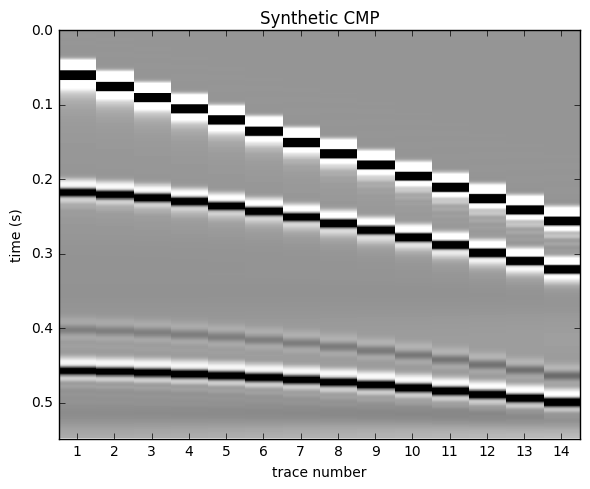

In [20]:
fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111)
ax.set_title('Synthetic CMP')
ax.set_xlabel('trace number')
ax.set_ylabel('time (s)')
cutoff = 0.1
ax.imshow(cmp, extent=[0.5, noffsets + 0.5, dt*nsamples, 0], 
          aspect=20, cmap='Greys', vmin=-cutoff, vmax=cutoff, 
          interpolation='nearest')
trace_numbers = list(range(1, noffsets + 1))
ax.set_xticks(trace_numbers)
fig.tight_layout()

The events that we can see in the CMP are (from top to bottom):
1. The direct wave.
2. The reflection on the first interface.
3. A multiple reflection on the first interface.
4. The reflection on the second interface.

## Building our NMO correction

The algorithm for NMO correction described in the tutorial is:

1. Start with an NMO gather filled with zeros.
2. For each point ($t_0, x$) in the NMO gather, do:

    * Calculate the reflection travel-time ($t$) given $v_{NMO}$.
    * Go to the trace at offset $x$ in the CMP and find the two samples before and the two samples after time $t$.
    * If $t$ is greater than the recording time or if it doesn't have two samples after it, skip the next two steps.
    * Use the amplitude in these four samples to interpolate the amplitude at time $t$.
    * Copy the interpolated amplitude to the NMO gather at ($t_0, x$).
    
We'll use three functions to implement this whole algorithm. First, let's start with a function that performs the overall correction, relying on some functions that we'll define later on.

In [ ]:
def nmo_correction(cmp, dt, offsets, velocities):
    """
    Performs NMO correction on the given CMP.
    
    Parameters
    ----------
    
    cmp : 2D array
        The CMP gather that we want to correct.
    dt : float
        The sampling interval.
    offsets : 1D array
        An array with the offset of each trace in the CMP.
    velocities : 1D array
        An array with the NMO velocity for each time. Should
        have the same number of elements as the CMP has samples.
        
    Returns
    -------
    
    nmo : 2D array
        The NMO corrected gather.
    """
    nmo = np.zeros_like(cmp)
    nsamples = cmp.shape[0]
    times = np.arange(0, nsamples*dt, dt)
    for i, t0 in enumerate(times):
        for j, x in enumerate(offsets):
            t = reflection_time(t0, x, velocities[i])
            amplitude = sample_trace(cmp[i, :], t, dt)
            # If the time t is outside of the CMP time range,
            # amplitude will be None.
            if amplitude is not None:
                nmo[i, j] = amplitude
    return nmo    

In [ ]:

            t = np.sqrt(t0**2 + o**2/v[i]**2)
            k = int(math.floor(t/dt))
            if k < times.size - 1:
                # Linear interpolation of the amplitude
                y0, y1 = CMP[k, j], CMP[k + 1, j]
                x0, x1 = times[k], times[k + 1]
                nmo[i, j] = y0 + (y1 - y0)*(t - x0)/(x1 - x0)